# Machine Learning Engineer Nanodegree
## Deep Learning
## Project: Build a Digit Recognition Program

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

----
## Step 1: Design and Test a Model Architecture
Design and implement a deep learning model that learns to recognize sequences of digits. Train the model using synthetic data generated by concatenating character images from [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html) or [MNIST](http://yann.lecun.com/exdb/mnist/). To produce a synthetic sequence of digits for testing, you can for example limit yourself to sequences up to five digits, and use five classifiers on top of your deep network. You would have to incorporate an additional ‘blank’ character to account for shorter number sequences.

There are various aspects to consider when thinking about this problem:
- Your model can be derived from a deep neural net or a convolutional network.
- You could experiment sharing or not the weights between the softmax classifiers.
- You can also use a recurrent network in your deep neural net to replace the classification layers and directly emit the sequence of digits one-at-a-time.

Here is an example of a [published baseline model on this problem](http://static.googleusercontent.com/media/research.google.com/en//pubs/archive/42241.pdf). ([video](https://www.youtube.com/watch?v=vGPI_JvLoN0))

### Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [1]:
from keras.datasets import mnist
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
from keras.utils import np_utils

import tensorflow as tf
from sklearn.metrics import confusion_matrix
import time
from datetime import timedelta
import math
import h5py

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

K.set_image_dim_ordering('th')

Using TensorFlow backend.


In [2]:
# We know that MNIST images are 28 pixels in each dimension.
img_size = 28

# Images are stored in one-dimensional arrays of this length.
img_size_flat = img_size * img_size

# Tuple with height and width of images used to reshape arrays.
img_shape = (img_size, img_size)

# Number of colour channels for the images: 1 channel for gray-scale.
num_channels = 1

# Number of classes, one class for each of 10 digits.
num_classes = 11

# Maximum number of digits.
max_num_digits = 5

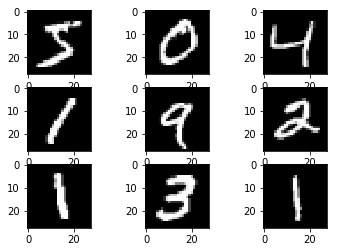

In [3]:
# referenced from 
# http://machinelearningmastery.com/image-augmentation-deep-learning-keras/

# load data
(X_train, y_train), (X_test, y_test) = mnist.load_data()

N_train = X_train.shape[0]
N_test = X_test.shape[0]

# add 20% of rows as spaces
X_train = np.r_[X_train, np.zeros((N_train / 5, img_size, img_size))]
X_test = np.r_[X_test, np.zeros((N_test / 5, img_size, img_size))]

y_train = np.r_[y_train, np.repeat(10, N_train / 5)]
y_test = np.r_[y_test, np.repeat(10, N_test / 5)]


# reshape to be [samples][pixels][width][height]
X_train = X_train.reshape(X_train.shape[0], num_channels, img_size, img_size) 
X_test = X_test.reshape(X_test.shape[0], num_channels, img_size, img_size) 
# convert from int to float
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# create a grid of 3x3 images
for i in range(0, 9):
    plt.subplot(330 + 1 + i)
    plt.imshow(X_train[i].reshape(28, 28), cmap=plt.get_cmap('gray'))
    # show the plot
plt.show()


In [4]:
train_batch_size = 250

In [5]:
# define data preparation
shift = 0.2
rotation_range = 15
datagen = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True,
                             rotation_range=rotation_range,
                             width_shift_range=shift, height_shift_range=shift)

# fit parameters from data
datagen.fit(X_train)

In [6]:
digit_1_iter = datagen.flow(X_train, y_train, batch_size=train_batch_size)
digit_2_iter = datagen.flow(X_train, y_train, batch_size=train_batch_size)
digit_3_iter = datagen.flow(X_train, y_train, batch_size=train_batch_size)
digit_4_iter = datagen.flow(X_train, y_train, batch_size=train_batch_size)
digit_5_iter = datagen.flow(X_train, y_train, batch_size=train_batch_size)

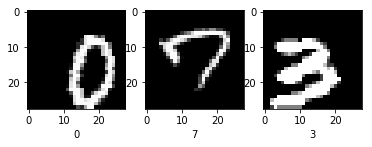

In [7]:
# configure batch size and retrieve one batch of images
for X_batch, y_batch in digit_1_iter:
    # create  grid of 3x3 images
    for i in range(0, 3):
        plt.subplot(130 + 1 + i)
        plt.imshow(X_batch[i].reshape(28, 28), cmap=plt.get_cmap('gray'))
        plt.xlabel(y_batch[i])
    # show the plot
    plt.show()
    break 
digit_1_iter.reset()

In [8]:
digit_1_iter.batch_index

0

In [9]:
x = tf.placeholder(tf.float32, shape=[None, img_size_flat * max_num_digits], name='x')

In [10]:
x_image = tf.reshape(x, [-1, img_size, img_size * max_num_digits, num_channels])

In [11]:
y_true = tf.placeholder(tf.float32, shape=[None, max_num_digits, num_classes], name='y_true')

In [12]:
y_true_cls = tf.argmax(y_true, dimension=2)

In [13]:
def new_weights(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.05))

In [14]:
def new_biases(length):
    return tf.Variable(tf.constant(0.05, shape=[length]))

In [15]:
def new_conv_layer(input,              # The previous layer.
                   num_input_channels, # Num. channels in prev. layer.
                   filter_size,        # Width and height of filters.
                   num_filters,        # Number of filters.
                   use_pooling=True,   # Use 2x2 max-pooling.
                   stride=1):          # Stride Length

    # Shape of the filter-weights for the convolution.
    # This format is determined by the TensorFlow API.
    shape = [filter_size, filter_size, num_input_channels, num_filters]

    # Create new weights aka. filters with the given shape.
    weights = new_weights(shape=shape)

    # Create new biases, one for each filter.
    biases = new_biases(length=num_filters)

    # Create the TensorFlow operation for convolution.
    # Note the strides are set to 1 in all dimensions.
    # The first and last stride must always be 1,
    # because the first is for the image-number and
    # the last is for the input-channel.
    # But e.g. strides=[1, 2, 2, 1] would mean that the filter
    # is moved 2 pixels across the x- and y-axis of the image.
    # The padding is set to 'SAME' which means the input image
    # is padded with zeroes so the size of the output is the same.
    layer = tf.nn.conv2d(input=input,
                         filter=weights,
                         strides=[1, 1, 1, 1],
                         padding='SAME')

    # Add the biases to the results of the convolution.
    # A bias-value is added to each filter-channel.
    layer += biases

    # Use pooling to down-sample the image resolution?
    if use_pooling:
        # This is 2x2 max-pooling, which means that we
        # consider 2x2 windows and select the largest value
        # in each window. Then we move 2 pixels to the next window.
        layer = tf.nn.max_pool(value=layer,
                               ksize=[1, 2, 2, 1],
                               strides=[1, stride, stride, 1],
                               padding='SAME')

    # Rectified Linear Unit (ReLU).
    # It calculates max(x, 0) for each input pixel x.
    # This adds some non-linearity to the formula and allows us
    # to learn more complicated functions.
    layer = tf.nn.relu(layer)

    # Note that ReLU is normally executed before the pooling,
    # but since relu(max_pool(x)) == max_pool(relu(x)) we can
    # save 75% of the relu-operations by max-pooling first.

    # We return both the resulting layer and the filter-weights
    # because we will plot the weights later.
    return layer, weights

In [16]:
def flatten_layer(layer):
    # Get the shape of the input layer.
    layer_shape = layer.get_shape()

    # The shape of the input layer is assumed to be:
    # layer_shape == [num_images, img_height, img_width, num_channels]

    # The number of features is: img_height * img_width * num_channels
    # We can use a function from TensorFlow to calculate this.
    num_features = layer_shape[1:4].num_elements()

    # Reshape the layer to [num_images, num_features].
    # Note that we just set the size of the second dimension
    # to num_features and the size of the first dimension to -1
    # which means the size in that dimension is calculated
    # so the total size of the tensor is unchanged from the reshaping.
    layer_flat = tf.reshape(layer, [-1, num_features])

    # The shape of the flattened layer is now:
    # [num_images, img_height * img_width * num_channels]

    # Return both the flattened layer and the number of features.
    return layer_flat, num_features

In [17]:
def new_fc_layer(input,          # The previous layer.
                 num_inputs,     # Num. inputs from prev. layer.
                 num_outputs,    # Num. outputs.
                 use_relu=True): # Use Rectified Linear Unit (ReLU)?

    # Create new weights and biases.
    weights = new_weights(shape=[num_inputs, num_outputs])
    biases = new_biases(length=num_outputs)

    # Calculate the layer as the matrix multiplication of
    # the input and weights, and then add the bias-values.
    layer = tf.matmul(input, weights) + biases

    # Use ReLU?
    if use_relu:
        layer = tf.nn.relu(layer)

    return layer

In [18]:
# First convolutional layer.
layer_conv1, weights_conv1 = \
    new_conv_layer(input=x_image,
                   num_input_channels=num_channels,
                   filter_size=5,
                   num_filters=48,
                   use_pooling=True)

# Second convolutional layer.
layer_conv2, weights_conv2 = \
    new_conv_layer(input=layer_conv1,
                   num_input_channels=48,
                   filter_size=5,
                   num_filters=64,
                   use_pooling=True,
                   stride=2)
    

# Third convolutional layer.
layer_conv3, weights_conv3 = \
    new_conv_layer(input=layer_conv2,
                   num_input_channels=64,
                   filter_size=5,
                   num_filters=128,
                   use_pooling=True)
    
    
# Fourth convolutional layer.
layer_conv4, weights_conv4 = \
    new_conv_layer(input=layer_conv3,
                   num_input_channels=128,
                   filter_size=5,
                   num_filters=160,
                   use_pooling=True,
                   stride=2)
    
    
# Fifth convolutional layer.
layer_conv5, weights_conv5 = \
    new_conv_layer(input=layer_conv4,
                   num_input_channels=160,
                   filter_size=5,
                   num_filters=192,
                   use_pooling=True)
    
    
# Sixth convolutional layer.
layer_conv6, weights_conv6 = \
    new_conv_layer(input=layer_conv5,
                   num_input_channels=192,
                   filter_size=5,
                   num_filters=192,
                   use_pooling=True,
                   stride=2)
    
    
# Seventh convolutional layer.
layer_conv7, weights_conv7 = \
    new_conv_layer(input=layer_conv6,
                   num_input_channels=192,
                   filter_size=5,
                   num_filters=192,
                   use_pooling=True)
    

# Eighth convolutional layer.
layer_conv8, weights_conv8 = \
    new_conv_layer(input=layer_conv7,
                   num_input_channels=192,
                   filter_size=5,
                   num_filters=192,
                   use_pooling=True,
                   stride=2)
    

# Flatten layer.
layer_flat, num_features = flatten_layer(layer_conv4)

# First fully-connected layer.
layer_fc1 = new_fc_layer(input=layer_flat,
                         num_inputs=num_features,
                         num_outputs=3072,
                         use_relu=True)

# Second fully-connected layer.
layer_fc2_digit_1 = new_fc_layer(input=layer_fc1,
                                 num_inputs=3072,
                                 num_outputs=num_classes,
                                 use_relu=False)

layer_fc2_digit_2 = new_fc_layer(input=layer_fc1,
                                 num_inputs=3072,
                                 num_outputs=num_classes,
                                 use_relu=False)

layer_fc2_digit_3 = new_fc_layer(input=layer_fc1,
                                 num_inputs=3072,
                                 num_outputs=num_classes,
                                 use_relu=False)

layer_fc2_digit_4 = new_fc_layer(input=layer_fc1,
                                 num_inputs=3072,
                                 num_outputs=num_classes,
                                 use_relu=False)

layer_fc2_digit_5 = new_fc_layer(input=layer_fc1,
                                 num_inputs=3072,
                                 num_outputs=num_classes,
                                 use_relu=False)


# Predicted class-label.
logit_1 = tf.nn.softmax(layer_fc2_digit_1)
y_pred_1 = tf.arg_max(logit_1, dimension=1)

# Predicted class-label.
logit_2 = tf.nn.softmax(layer_fc2_digit_2)
y_pred_2 = tf.arg_max(logit_2, dimension=1)

# Predicted class-label.
logit_3 = tf.nn.softmax(layer_fc2_digit_3)
y_pred_3 = tf.arg_max(logit_3, dimension=1)

# Predicted class-label.
logit_4 = tf.nn.softmax(layer_fc2_digit_4)
y_pred_4 = tf.arg_max(logit_4, dimension=1)

# Predicted class-label.
logit_5 = tf.nn.softmax(layer_fc2_digit_5)
y_pred_5 = tf.arg_max(logit_5, dimension=1)

y_pred_cls = tf.transpose(tf.stack([y_pred_1, y_pred_2, y_pred_3, y_pred_4, y_pred_5]))

# Cross-entropy for the classification of each image.
cross_entropy_1 = \
    tf.nn.softmax_cross_entropy_with_logits(logits=layer_fc2_digit_1,
                                            labels=y_true[:, 0, :])

# Loss aka. cost-measure.
# This is the scalar value that must be minimized.
loss_1 = tf.reduce_mean(cross_entropy_1)

# Cross-entropy for the classification of each image.
cross_entropy_2 = \
    tf.nn.softmax_cross_entropy_with_logits(logits=layer_fc2_digit_2,
                                            labels=y_true[:, 1, :])

# Loss aka. cost-measure.
# This is the scalar value that must be minimized.
loss_2 = tf.reduce_mean(cross_entropy_2)


# Cross-entropy for the classification of each image.
cross_entropy_3 = \
    tf.nn.softmax_cross_entropy_with_logits(logits=layer_fc2_digit_3,
                                            labels=y_true[:, 2, :])

# Loss aka. cost-measure.
# This is the scalar value that must be minimized.
loss_3 = tf.reduce_mean(cross_entropy_3)


# Cross-entropy for the classification of each image.
cross_entropy_4 = \
    tf.nn.softmax_cross_entropy_with_logits(logits=layer_fc2_digit_4,
                                            labels=y_true[:, 3, :])

# Loss aka. cost-measure.
# This is the scalar value that must be minimized.
loss_4 = tf.reduce_mean(cross_entropy_4)


# Cross-entropy for the classification of each image.
cross_entropy_5 = \
    tf.nn.softmax_cross_entropy_with_logits(logits=layer_fc2_digit_5,
                                            labels=y_true[:, 4, :])

# Loss aka. cost-measure.
# This is the scalar value that must be minimized.
loss_5 = tf.reduce_mean(cross_entropy_5)

loss = loss_1 + loss_2 + loss_3 + loss_4 + loss_5

In [19]:
optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(loss)

In [20]:
correct_prediction = tf.equal(y_pred_cls, y_true_cls)

In [21]:
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [22]:
# session = tf.Session()
# new_saver = tf.train.import_meta_graph('./models/svhn_model/the_svhn_model.meta')
# new_saver.restore(session, tf.train.latest_checkpoint('./models/svhn_model/'))

In [23]:
# tf.reset_default_graph()
session = tf.Session()

In [24]:
session.run(tf.global_variables_initializer())

In [25]:
# Counter for total number of iterations performed so far.
total_iterations = 0

def optimize(num_iterations):
    # Ensure we update the global variable rather than a local copy.
    global total_iterations

    # Start-time used for printing time-usage below.
    start_time = time.time()

    for i in range(total_iterations,
                   total_iterations + num_iterations):

        # Get a batch of training examples.
        # x_batch now holds a batch of images and
        # y_true_batch are the true labels for those images.
        x_batch_1, y_true_batch_1 = digit_1_iter.next()
        x_batch_2, y_true_batch_2 = digit_2_iter.next()
        x_batch_3, y_true_batch_3 = digit_3_iter.next()
        x_batch_4, y_true_batch_4 = digit_4_iter.next()
        x_batch_5, y_true_batch_5 = digit_5_iter.next()
        
        x_batch = np.c_[x_batch_1, x_batch_2, x_batch_3, x_batch_4, x_batch_5]
        y_true_batch = np.c_[np_utils.to_categorical(y_true_batch_1, nb_classes=num_classes),
                             np_utils.to_categorical(y_true_batch_2, nb_classes=num_classes),
                             np_utils.to_categorical(y_true_batch_3, nb_classes=num_classes),
                             np_utils.to_categorical(y_true_batch_4, nb_classes=num_classes),
                             np_utils.to_categorical(y_true_batch_5, nb_classes=num_classes)]
        
        # Put the batch into a dict with the proper names
        # for placeholder variables in the TensorFlow graph.
        feed_dict_train = {x: x_batch.reshape(-1, img_size_flat * max_num_digits),
                           y_true: y_true_batch.reshape((-1, max_num_digits, num_classes))}

        # Run the optimizer using this batch of training data.
        # TensorFlow assigns the variables in feed_dict_train
        # to the placeholder variables and then runs the optimizer.
        session.run(optimizer, feed_dict=feed_dict_train)
        
        # Calculate the accuracy on the training-set.
        acc = session.run(accuracy, feed_dict=feed_dict_train)  
        
        # Print status every 100 iterations.
        if i % 128 == 0:
            # Message for printing.
            msg = "Optimization Iteration: {0:>6}, Training Accuracy: {1:>6.1%}"

            # Print it.
            print(msg.format(i + 1, acc))

    # Update the total number of iterations performed.
    total_iterations += num_iterations

    # Ending time.
    end_time = time.time()

    # Difference between start and end-times.
    time_dif = end_time - start_time

    # Print the time-usage.
    print("Time usage: " + str(timedelta(seconds=int(round(time_dif)))))

In [26]:
optimize(num_iterations=5000)

Optimization Iteration:      1, Training Accuracy:  14.4%
Optimization Iteration:    129, Training Accuracy:  64.5%
Optimization Iteration:    257, Training Accuracy:  87.4%
Optimization Iteration:    385, Training Accuracy:  92.6%
Optimization Iteration:    513, Training Accuracy:  96.4%
Optimization Iteration:    641, Training Accuracy:  94.6%
Optimization Iteration:    769, Training Accuracy:  96.0%
Optimization Iteration:    897, Training Accuracy:  97.2%
Optimization Iteration:   1025, Training Accuracy:  96.7%
Optimization Iteration:   1153, Training Accuracy:  96.8%
Optimization Iteration:   1281, Training Accuracy:  97.1%
Optimization Iteration:   1409, Training Accuracy:  97.8%
Optimization Iteration:   1537, Training Accuracy:  98.2%
Optimization Iteration:   1665, Training Accuracy:  98.6%
Optimization Iteration:   1793, Training Accuracy:  97.8%
Optimization Iteration:   1921, Training Accuracy:  98.2%
Optimization Iteration:   2049, Training Accuracy:  98.6%
Optimization I

### Question 1
_What approach did you take in coming up with a solution to this problem?_

**Answer:**


1. Loaded data via keras.  (Data already in library)
2. Preprocessed data
 - Reshaped array into image matrix
 - Preprocessed data using keras ImageDataGenerator class
   - Random shift 20%
   - Random rotation range 15 degrees
   - Center and scale

3. Add 20% of numbers as complete blank spaces
   
4. Create 5 randomly shuffled versions of this data to create 5 digits

5. Feed into model.

### Question 2
_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)_

**Answer:**

The type of model was a convolution neural net CNN.

I tried following the Goodfellow paper as close as possible using:

 - Convolution layer 1 - 48 units,  2X2 maxpooling, stride=2, padding=same
 - Convolution layer 2 - 64 units,  stride=1, padding=same
 - Convolution layer 3 - 128 units, 2X2 maxpooling, stride=2, padding=same
 - Convolution layer 4 - 160 units, stride=1, padding=same
 - Convolution layer 5 - 192 units, 2X2 maxpooling, stride=2, padding=same
 - Convolution layer 6 - 192 units, stride=1, padding=same
 - Convolution layer 7 - 192 units, 2X2 maxpooling, stride=2, padding=same
 - Convolution layer 8 - 192 units, stride=1, padding=same
 - Fully connected layer 3072 Relu units
 - 5 fully connected layers each with 11 softmax units

### Question 3
_How did you train your model? How did you generate your synthetic dataset?_ Include examples of images from the synthetic data you constructed.

**Answer:**
As alluded to in Question one, I created my synthetic dataset by concatenating shuffled transformed (shifted, rotated, centered and scaled, inserted spaces) from the MNIST data set to simulating the number of digits ranging from 0 - 5. 

The model was trained feeding it up with 1875 batches of 250 images with size: 28x140, as input, and labels to which was applied one-hot encoding, as output.

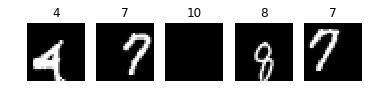

In [27]:
# configure batch size and retrieve one batch of images
for X_batch, y_batch in digit_1_iter:
    # create  grid of 3x3 images
    for i in range(0, 5):
        plt.subplot(150 + 1 + i)
        plt.imshow(X_batch[i].reshape(28, 28), cmap=plt.get_cmap('gray')) 
        plt.axis('off')
        plt.title(y_batch[i])
    # show the plot
    break 

plt.show()
digit_1_iter.reset()

----
## Step 2: Train a Model on a Realistic Dataset
Once you have settled on a good architecture, you can train your model on real data. In particular, the [Street View House Numbers (SVHN)](http://ufldl.stanford.edu/housenumbers/) dataset is a good large-scale dataset collected from house numbers in Google Street View. Training on this more challenging dataset, where the digits are not neatly lined-up and have various skews, fonts and colors, likely means you have to do some hyperparameter exploration to perform well.

### Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [28]:
f = h5py.File("SVHN.hdf5", "r")

X_train = f["X_train"].value
X_validation = f["X_validation"].value 
X_test = f["X_test"].value

y_train = f["y_train"].value
y_validation = f["y_validation"].value 
y_test = f["y_test"].value

length_train = f["length_train"].value 
length_validation = f["length_validation"].value 
length_test = f["length_test"].value

digit_coords_train = f["digit_coords_train"].value
digit_coords_validation = f["digit_coords_validation"].value
digit_coords_test = f["digit_coords_test"].value

f.close()

In [29]:
# We know that MNIST images are 28 pixels in each dimension.
img_size =54

# Number of colour channels for the images: 1 channel for gray-scale.
num_channels = 3

# Number of coordinates used to describe the bounding box.
num_coords = 4

# Images are stored in one-dimensional arrays of this length.
img_size_flat = img_size * img_size * num_channels

# Tuple with height and width of images used to reshape arrays.
img_shape = (img_size, img_size, num_channels)


# Number of classes, one class for each of 10 digits.
num_classes = 11

# Maximum number of digits.
max_num_digits = 5

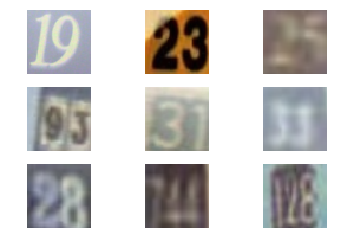

In [30]:
# create a grid of 3x3 images
for i in range(0, 9):
    plt.subplot(330 + 1 + i)
    plt.imshow(X_train[i].reshape(img_shape))
    plt.axis('off')
# show the plot
plt.show()    

In [31]:
# define data preparation
datagen = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True)

# fit parameters from data
datagen.fit(X_train.reshape((-1, num_channels, img_size, img_size)))

In [32]:
train_batch_size = 256

In [33]:
batch_iter = datagen.flow(X_train.reshape((-1, num_channels, img_size, img_size)), 
                          range(len(y_train)), 
                          batch_size=train_batch_size, 
                          shuffle=False)

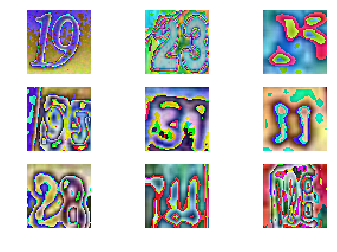

In [34]:
# configure batch size and retrieve one batch of images
for X_batch, _ in batch_iter:
    # create a grid of 3x3 images
    for i in range(0, 9):
        plt.subplot(330 + 1 + i)
        plt.imshow(X_batch[i].reshape(img_shape))
        plt.axis('off')
    # show the plot
    plt.show()
    break 
batch_iter.reset()

In [35]:
batch_iter.batch_index

0

In [36]:
img_size_flat

8748

In [37]:
X_train.shape

(25050, 8748)

In [38]:
x = tf.placeholder(tf.float32, shape=[None, img_size_flat], name='x')

In [39]:
x_image = tf.reshape(x, [-1, img_size, img_size, num_channels])

In [40]:
y_true = tf.placeholder(tf.float32, shape=[None, max_num_digits, num_classes], name='y_true')

In [41]:
y_true_cls = tf.argmax(y_true, dimension=2)

In [42]:
length_true = tf.placeholder(tf.float32, shape=[None, max_num_digits], name='length_true')

In [43]:
length_true_cls = tf.argmax(length_true, dimension=1)

In [44]:
digit_coords_true = tf.placeholder(tf.float32, shape=[None, 20], name='length_true')

In [45]:
def new_weights(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.05))

In [46]:
def new_biases(length):
    return tf.Variable(tf.constant(0.05, shape=[length]))

In [47]:
def new_conv_layer(input,              # The previous layer.
                   num_input_channels, # Num. channels in prev. layer.
                   filter_size,        # Width and height of filters.
                   num_filters,        # Number of filters.
                   use_pooling=True,   # Use 2x2 max-pooling.
                   stride=1,           # Stride Length
                   batch_norm=False):  # True when Training False when testing
           

    # Shape of the filter-weights for the convolution.
    # This format is determined by the TensorFlow API.
    shape = [filter_size, filter_size, num_input_channels, num_filters]

    # Create new weights aka. filters with the given shape.
    weights = new_weights(shape=shape)

    # Create new biases, one for each filter.
    biases = new_biases(length=num_filters)

    # Create the TensorFlow operation for convolution.
    # Note the strides are set to 1 in all dimensions.
    # The first and last stride must always be 1,
    # because the first is for the image-number and
    # the last is for the input-channel.
    # But e.g. strides=[1, 2, 2, 1] would mean that the filter
    # is moved 2 pixels across the x- and y-axis of the image.
    # The padding is set to 'SAME' which means the input image
    # is padded with zeroes so the size of the output is the same.
    layer = tf.nn.conv2d(input=input,
                         filter=weights,
                         strides=[1, 1, 1, 1],
                         padding='SAME')

    # Add the biases to the results of the convolution.
    # A bias-value is added to each filter-channel.
    layer += biases

    if batch_norm:
        # Small epsilon value for the BN transform
        epsilon = 1e-3
        batch_mean, batch_var = tf.nn.moments(layer,[0])
        scale = tf.Variable(tf.ones(num_filters))
        beta = tf.Variable(tf.zeros(num_filters))
        layer = tf.nn.batch_normalization(layer,batch_mean, batch_var, beta, scale, epsilon)

    # Use pooling to down-sample the image resolution?
    if use_pooling:
        # This is 2x2 max-pooling, which means that we
        # consider 2x2 windows and select the largest value
        # in each window. Then we move 2 pixels to the next window.
        layer = tf.nn.max_pool(value=layer,
                               ksize=[1, 2, 2, 1],
                               strides=[1, stride, stride, 1],
                               padding='SAME')
        

        
        

    # Rectified Linear Unit (ReLU).
    # It calculates max(x, 0) for each input pixel x.
    # This adds some non-linearity to the formula and allows us
    # to learn more complicated functions.
    layer = tf.nn.relu(layer)

    # Note that ReLU is normally executed before the pooling,
    # but since relu(max_pool(x)) == max_pool(relu(x)) we can
    # save 75% of the relu-operations by max-pooling first.

    # We return both the resulting layer and the filter-weights
    # because we will plot the weights later.
    return layer, weights

In [48]:
def flatten_layer(layer):
    # Get the shape of the input layer.
    layer_shape = layer.get_shape()

    # The shape of the input layer is assumed to be:
    # layer_shape == [num_images, img_height, img_width, num_channels]

    # The number of features is: img_height * img_width * num_channels
    # We can use a function from TensorFlow to calculate this.
    num_features = layer_shape[1:4].num_elements()

    # Reshape the layer to [num_images, num_features].
    # Note that we just set the size of the second dimension
    # to num_features and the size of the first dimension to -1
    # which means the size in that dimension is calculated
    # so the total size of the tensor is unchanged from the reshaping.
    layer_flat = tf.reshape(layer, [-1, num_features])

    # The shape of the flattened layer is now:
    # [num_images, img_height * img_width * num_channels]

    # Return both the flattened layer and the number of features.
    return layer_flat, num_features

In [49]:
def new_fc_layer(input,          # The previous layer.
                 num_inputs,     # Num. inputs from prev. layer.
                 num_outputs,    # Num. outputs.
                 use_relu=True): # Use Rectified Linear Unit (ReLU)?

    # Create new weights and biases.
    weights = new_weights(shape=[num_inputs, num_outputs])
    biases = new_biases(length=num_outputs)

    # Calculate the layer as the matrix multiplication of
    # the input and weights, and then add the bias-values.
    layer = tf.matmul(input, weights) + biases

    # Use ReLU?
    if use_relu:
        layer = tf.nn.relu(layer)

    return layer

In [50]:
"""
Code is from:
https://github.com/philipperemy/tensorflow-maxout/blob/master/maxout.py
Maxout OP from https://arxiv.org/abs/1302.4389
Max pooling is performed in given filter/channel dimension. This can also be
used after fully-connected layers to reduce number of features.
Args:
    inputs: A Tensor on which maxout will be performed
    num_units: Specifies how many features will remain after max pooling at the
      channel dimension. This must be multiple of number of channels.
    axis: The dimension where max pooling will be performed. Default is the
      last dimension.
    outputs_collections: The collections to which the outputs are added.
    scope: Optional scope for name_scope.
Returns:
    A `Tensor` representing the results of the pooling operation.
Raises:
    ValueError: if num_units is not multiple of number of features.
"""


def max_out(inputs, num_units, axis=None):
    shape = inputs.get_shape().as_list()
    if shape[0] is None:
        shape[0] = -1
    if axis is None:  # Assume that channel is the last dimension
        axis = -1
    num_channels = shape[axis]
    if num_channels % num_units:
        raise ValueError('number of features({}) is not '
                         'a multiple of num_units({})'.format(num_channels, num_units))
    shape[axis] = num_units
    shape += [num_channels // num_units]
    outputs = tf.reduce_max(tf.reshape(inputs, shape), -1, keep_dims=False)
    return outputs

In [51]:
x_max_out = max_out(x_image, num_channels)

In [52]:
# First convolutional layer.
layer_conv1, weights_conv1 = \
    new_conv_layer(input=x_max_out,
                   num_input_channels=num_channels,
                   filter_size=5,
                   num_filters=48,
                   use_pooling=True,
                   batch_norm=True)

# Second convolutional layer.
layer_conv2, weights_conv2 = \
    new_conv_layer(input=layer_conv1,
                   num_input_channels=48,
                   filter_size=5,
                   num_filters=64,
                   use_pooling=True,
                   stride=2)
    

# Third convolutional layer.
layer_conv3, weights_conv3 = \
    new_conv_layer(input=layer_conv2,
                   num_input_channels=64,
                   filter_size=5,
                   num_filters=128,
                   use_pooling=True)
    
    
# Fourth convolutional layer.
layer_conv4, weights_conv4 = \
    new_conv_layer(input=layer_conv3,
                   num_input_channels=128,
                   filter_size=5,
                   num_filters=160,
                   use_pooling=True,
                   stride=2)
    
    
# Fifth convolutional layer.
layer_conv5, weights_conv5 = \
    new_conv_layer(input=layer_conv4,
                   num_input_channels=160,
                   filter_size=5,
                   num_filters=192,
                   use_pooling=True)
    
    
# Sixth convolutional layer.
layer_conv6, weights_conv6 = \
    new_conv_layer(input=layer_conv5,
                   num_input_channels=192,
                   filter_size=5,
                   num_filters=192,
                   use_pooling=True,
                   stride=2)
    
    
# Seventh convolutional layer.
layer_conv7, weights_conv7 = \
    new_conv_layer(input=layer_conv6,
                   num_input_channels=192,
                   filter_size=5,
                   num_filters=192,
                   use_pooling=True)
    

# Eighth convolutional layer.
layer_conv8, weights_conv8 = \
    new_conv_layer(input=layer_conv7,
                   num_input_channels=192,
                   filter_size=5,
                   num_filters=192,
                   use_pooling=True,
                   stride=2)
    

# Flatten layer.
layer_flat, num_features = flatten_layer(layer_conv4)

keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(layer_flat, keep_prob)

# First fully-connected layer.
layer_fc1 = new_fc_layer(input=h_fc1_drop,
                         num_inputs=num_features,
                         num_outputs=3072,
                         use_relu=True)

# Second fully-connected layer.
layer_fc2_digit_1 = new_fc_layer(input=layer_fc1,
                                 num_inputs=3072,
                                 num_outputs=num_classes,
                                 use_relu=False)

layer_fc2_digit_2 = new_fc_layer(input=layer_fc1,
                                 num_inputs=3072,
                                 num_outputs=num_classes,
                                 use_relu=False)

layer_fc2_digit_3 = new_fc_layer(input=layer_fc1,
                                 num_inputs=3072,
                                 num_outputs=num_classes,
                                 use_relu=False)

layer_fc2_digit_4 = new_fc_layer(input=layer_fc1,
                                 num_inputs=3072,
                                 num_outputs=num_classes,
                                 use_relu=False)

layer_fc2_digit_5 = new_fc_layer(input=layer_fc1,
                                 num_inputs=3072,
                                 num_outputs=num_classes,
                                 use_relu=False)

layer_fc2_length  = new_fc_layer(input=layer_fc1,
                                 num_inputs=3072,
                                 num_outputs=max_num_digits,
                                 use_relu=False)


# Bounding box predictions using 4 outputs
# from fully connected layer with Relu activation
digit_coords_preds       = new_fc_layer(input=layer_fc1,
                                        num_inputs=3072,
                                        num_outputs=20,
                                        use_relu=True)


# Predicted class-label.
logit_1 = tf.nn.softmax(layer_fc2_digit_1)
y_pred_1 = tf.arg_max(logit_1, dimension=1)

# Predicted class-label.
logit_2 = tf.nn.softmax(layer_fc2_digit_2)
y_pred_2 = tf.arg_max(logit_2, dimension=1)

# Predicted class-label.
logit_3 = tf.nn.softmax(layer_fc2_digit_3)
y_pred_3 = tf.arg_max(logit_3, dimension=1)

# Predicted class-label.
logit_4 = tf.nn.softmax(layer_fc2_digit_4)
y_pred_4 = tf.arg_max(logit_4, dimension=1)

# Predicted class-label.
logit_5 = tf.nn.softmax(layer_fc2_digit_5)
y_pred_5 = tf.arg_max(logit_5, dimension=1)

# Predicted digit length.
logit_length = tf.nn.softmax(layer_fc2_length)
length_pred = tf.arg_max(logit_length, dimension=1)


y_pred_cls = tf.transpose(tf.stack([y_pred_1, y_pred_2, y_pred_3, y_pred_4, y_pred_5]))

# Cross-entropy for the classification of each image.
cross_entropy_1 = \
    tf.nn.softmax_cross_entropy_with_logits(logits=layer_fc2_digit_1,
                                            labels=y_true[:, 0, :])

# Loss aka. cost-measure.
# This is the scalar value that must be minimized.
loss_1 = tf.reduce_mean(cross_entropy_1)

# Cross-entropy for the classification of each image.
cross_entropy_2 = \
    tf.nn.softmax_cross_entropy_with_logits(logits=layer_fc2_digit_2,
                                            labels=y_true[:, 1, :])

# Loss aka. cost-measure.
# This is the scalar value that must be minimized.
loss_2 = tf.reduce_mean(cross_entropy_2)


# Cross-entropy for the classification of each image.
cross_entropy_3 = \
    tf.nn.softmax_cross_entropy_with_logits(logits=layer_fc2_digit_3,
                                            labels=y_true[:, 2, :])

# Loss aka. cost-measure.
# This is the scalar value that must be minimized.
loss_3 = tf.reduce_mean(cross_entropy_3)


# Cross-entropy for the classification of each image.
cross_entropy_4 = \
    tf.nn.softmax_cross_entropy_with_logits(logits=layer_fc2_digit_4,
                                            labels=y_true[:, 3, :])

# Loss aka. cost-measure.
# This is the scalar value that must be minimized.
loss_4 = tf.reduce_mean(cross_entropy_4)


# Cross-entropy for the classification of each image.
cross_entropy_5 = \
    tf.nn.softmax_cross_entropy_with_logits(logits=layer_fc2_digit_5,
                                            labels=y_true[:, 4, :])

# Loss aka. cost-measure.
# This is the scalar value that must be minimized.
loss_5 = tf.reduce_mean(cross_entropy_5)

# Cross-entropy for the classification of each image.
cross_entropy_6 = \
    tf.nn.softmax_cross_entropy_with_logits(logits=layer_fc2_length,
                                            labels=length_true)

# Loss aka. cost-measure.
# This is the scalar value that must be minimized.
loss_6 = tf.reduce_mean(cross_entropy_6)

# Bounding box cost-measure.
l2_loss_7 = \
    tf.nn.l2_loss(digit_coords_true - digit_coords_preds) 
    
loss_7 = tf.reduce_mean(l2_loss_7)



loss = loss_1 + loss_2 + loss_3 + loss_4 + loss_5 + loss_6 + loss_7

In [53]:
optimizer = tf.train.AdamOptimizer(learning_rate=5e-5).minimize(loss)

In [54]:
correct_prediction = tf.equal(y_pred_cls, y_true_cls)

In [55]:
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [56]:
# tf.reset_default_graph()
session = tf.Session()

In [57]:
# session = tf.Session()
# new_saver = tf.train.import_meta_graph('svhn model/the_svhn_model.meta')
# new_saver.restore(session, tf.train.latest_checkpoint('svhn model/'))

In [58]:
session.run(tf.global_variables_initializer())

In [59]:
# Counter for total number of iterations performed so far.
total_iterations = 0

def optimize(num_iterations):
    # Ensure we update the global variable rather than a local copy.
    global total_iterations

    # Start-time used for printing time-usage below.
    start_time = time.time()

    for i in range(total_iterations,
                   total_iterations + num_iterations):

        # Get a batch of training examples.
        # x_batch now holds a batch of images and
        # y_true_batch are the true labels for those images.
        x_batch, idx_batch = batch_iter.next()
        y_true_batch = y_train[idx_batch]
        length_batch = length_train[idx_batch]
        digit_coords_batch = digit_coords_train[idx_batch]
        
        # Put the batch into a dict with the proper names
        # for placeholder variables in the TensorFlow graph.
        feed_dict_train = {x: x_batch.reshape((-1, ) + (img_size_flat,)),
                           y_true: y_true_batch,
                           length_true: length_batch,
                           digit_coords_true: digit_coords_batch,
                           keep_prob: 0.5}

        # Run the optimizer using this batch of training data.
        # TensorFlow assigns the variables in feed_dict_train
        # to the placeholder variables and then runs the optimizer.
        session.run(optimizer, feed_dict=feed_dict_train)
        
        # Calculate the accuracy on the training-set.
        acc = session.run(accuracy, feed_dict=feed_dict_train)  
        
        # Print status every 100 iterations.
        if i % 250 == 0:
            # Message for printing.
            msg = "Optimization Iteration: {0:>6}, Training Accuracy: {1:>6.1%}"

            # Print it.
            print(msg.format(i + 1, acc))

    # Update the total number of iterations performed.
    total_iterations += num_iterations

    # Ending time.
    end_time = time.time()

    # Difference between start and end-times.
    time_dif = end_time - start_time

    # Print the time-usage.
    print("Time usage: " + str(timedelta(seconds=int(round(time_dif)))))

In [60]:
optimize(num_iterations=20000)

Optimization Iteration:      1, Training Accuracy:   7.5%
Optimization Iteration:    251, Training Accuracy:  53.8%
Optimization Iteration:    501, Training Accuracy:  52.1%
Optimization Iteration:    751, Training Accuracy:  55.7%
Optimization Iteration:   1001, Training Accuracy:  55.7%
Optimization Iteration:   1251, Training Accuracy:  54.1%
Optimization Iteration:   1501, Training Accuracy:  54.4%
Optimization Iteration:   1751, Training Accuracy:  55.3%
Optimization Iteration:   2001, Training Accuracy:  56.7%
Optimization Iteration:   2251, Training Accuracy:  57.2%
Optimization Iteration:   2501, Training Accuracy:  55.5%
Optimization Iteration:   2751, Training Accuracy:  55.5%
Optimization Iteration:   3001, Training Accuracy:  57.4%
Optimization Iteration:   3251, Training Accuracy:  55.3%
Optimization Iteration:   3501, Training Accuracy:  56.5%
Optimization Iteration:   3751, Training Accuracy:  55.0%
Optimization Iteration:   4001, Training Accuracy:  57.0%
Optimization I

In [61]:
# Code sited from:
# http://ronny.rest/tutorials/lesson/intersect_of_union/
def batch_iou(a, b, epsilon=1e-5):
    """ Given two arrays `a` and `b` where each row contains a bounding
        box defined as a list of four numbers:
            [x1,y1,x2,y2]
        where:
            x1,y1 represent the upper left corner
            x2,y2 represent the lower right corner
        It returns the Intersect of Union scores for each corresponding
        pair of boxes.

    Args:
        a:          (numpy array) each row containing [x1,y1,x2,y2] coordinates
        b:          (numpy array) each row containing [x1,y1,x2,y2] coordinates
        epsilon:    (float) Small value to prevent division by zero

    Returns:
        (numpy array) The Intersect of Union scores for each pair of bounding
        boxes.
    """
    # COORDINATES OF THE INTERSECTION BOXES
    x1 = np.array([a[:, 0], b[:, 0]]).max(axis=0)
    y1 = np.array([a[:, 1], b[:, 1]]).max(axis=0)
    x2 = np.array([a[:, 2], b[:, 2]]).min(axis=0)
    y2 = np.array([a[:, 3], b[:, 3]]).min(axis=0)

    # AREAS OF OVERLAP - Area where the boxes intersect
    width = (x2 - x1)
    height = (y2 - y1)

    # handle case where there is NO overlap
    width[width < 0] = 0
    height[height < 0] = 0

    area_overlap = width * height


    # COMBINED AREAS
    area_a = (a[:, 2] - a[:, 0]) * (a[:, 3] - a[:, 1])
    area_b = (b[:, 2] - b[:, 0]) * (b[:, 3] - b[:, 1])
    area_combined = area_a + area_b - area_overlap


    # RATIO OF AREA OF OVERLAP OVER COMBINED AREA
    iou = area_overlap / (area_combined + epsilon)

    return iou

In [62]:
def print_bounding_box_accuracy():
    
    # Number of images in the test-set.
    num_test = X_test.shape[0]

    # Allocate an array for the predicted classes which
    # will be calculated in batches and filled into this array.
   
    a = tf.reshape(digit_coords_true, [-1, num_coords])
    b = tf.reshape(digit_coords_preds, [-1, num_coords])
    
    a_preds  = np.zeros(shape=(num_test, num_coords))
    b_preds  = np.zeros(shape=(num_test, num_coords))
    iou_accs = np.zeros(shape=(num_test,))

    # Now calculate the predicted classes for the batches.
    # We will just iterate through all the batches.
    # There might be a more clever and Pythonic way of doing this.

    # The starting index for the next batch is denoted i.
    i = 0

    while i < num_test:
        # The ending index for the next batch is denoted j.
        j = min(i + test_batch_size, num_test)

        # Get the images from the test-set between index i and j.
        images = X_test[i:j, :]

        # Get the associated labels.
        labels = y_test[i:j, :]
        
        # Get the associated lengths.
        length_batch = length_test[i:j, :]
        
        # Get the associated coordinates.
        digit_coords_batch = digit_coords_test[i:j, :]

        # Create a feed-dict with these images and labels.
        feed_dict = {x: images,
                     y_true: labels,
                     length_true: length_batch,
                     digit_coords_true: digit_coords_batch,
                     keep_prob: 1}


        # Put the batch into a dict with the proper names
        # for placeholder variables in the TensorFlow graph.
        num_test = None
        feed_dict_test  = {x: X_test.reshape((-1, ) + (img_size_flat,))[: num_test],
                           y_true: y_test[: num_test],
                           length_true: length_test[: num_test],
                           digit_coords_true: digit_coords_test[: num_test],
                           keep_prob: 1}
        
        # Calculate the predicted class using TensorFlow.
        a_preds[i:j] = session.run(a[i:j], feed_dict=feed_dict)
        b_preds[i:j] = session.run(b[i:j], feed_dict=feed_dict)
        iou_accs[i:j] = batch_iou(a_preds[i:j], b_preds[i:j])

        # Set the start-index for the next batch to the
        # end-index of the current batch.
        i = j

        
    bounding_box_accuracy = np.mean(iou_accs)
    print "Accuracy on bounding boxes is {}%".format(np.round(bounding_box_accuracy * 100, 2))

In [63]:
# Code from:
# https://github.com/Hvass-Labs/TensorFlow-Tutorials/blob/master/03_PrettyTensor.ipynb
test_batch_size = 256
def print_test_accuracy():
    
    # Number of images in the test-set.
    num_test = X_test.shape[0]

    # Allocate an array for the predicted classes which
    # will be calculated in batches and filled into this array.
    cls_pred = np.zeros(shape=(num_test,max_num_digits), dtype=np.int)

    # Now calculate the predicted classes for the batches.
    # We will just iterate through all the batches.
    # There might be a more clever and Pythonic way of doing this.

    # The starting index for the next batch is denoted i.
    i = 0

    while i < num_test:
        # The ending index for the next batch is denoted j.
        j = min(i + test_batch_size, num_test)

        # Get the images from the test-set between index i and j.
        images = X_test[i:j, :]

        # Get the associated labels.
        labels = y_test[i:j, :]
        
        # Get the associated lengths.
        length_batch = length_test[i:j, :]
        
        # Get the associated coordinates.
        digit_coords_batch = digit_coords_test[i:j, :]

        # Create a feed-dict with these images and labels.
        feed_dict = {x: images,
                     y_true: labels,
                     length_true: length_batch,
                     digit_coords_true: digit_coords_batch,
                     keep_prob: 1}

        # Calculate the predicted class using TensorFlow.
        cls_pred[i:j] = session.run(y_pred_cls, feed_dict=feed_dict)

        # Set the start-index for the next batch to the
        # end-index of the current batch.
        i = j

    # Convenience variable for the true class-numbers of the test-set.
    cls_true = np.argmax(y_test[:num_test], 2)
    # Create a boolean array whether each image is correctly classified.
    correct = (cls_true == cls_pred)
    # Calculate the number of correctly classified images.
    # When summing a boolean array, False means 0 and True means 1.
    correct_sum = correct.sum()
    
    # Classification accuracy is the number of correctly classified
    # images divided by the total number of images in the test-set.
    acc = float(correct_sum) / num_test / max_num_digits

    # Print the accuracy.
    msg = "Accuracy on Test-Set: {0:.1%} ({1} / {2})"
    print(msg.format(acc, correct_sum, num_test * max_num_digits))

In [64]:
print_bounding_box_accuracy()

Accuracy on bounding boxes is 0.0%


In [65]:
print_test_accuracy()

Accuracy on Test-Set: 85.4% (55770 / 65340)


### Question 4
_Describe how you set up the training and testing data for your model. How does the model perform on a realistic dataset?_

**Answer:**

I tried to follow the goodwill paper as much as possible.

1. Locate image via bounding box then expand bounding box by 30%
2. Crop image then resize to 64 X 64.
3. Then crop a 54 X 54 image from a random location to simulate a shift.
4. Collect lenght data in .mat file
5. Collect bounding box data (20 dimension vector), and normalize so that that they (original images) are shape agnostic

This model is identical to the MNIST model except that the inputs were batch normalized and the first layer contained maxout units.  The fully connected layer had dropout units with keep probability of 50%. Also there was an additional output relu layer that contained 20 unit for the bounding box predictions.

### Question 5
_What changes did you have to make, if any, to achieve "good" results? Were there any options you explored that made the results worse?_

**Answer:**

A lot of the changes made were really based on getting the model to work at all as I was learning Tensorflow.   For instance version of tensorflow played impact in terms of how to save and load the model and the accesability of numpy-like functions available in the newer version.  Unfortunately I did not have the luxury to change the model parameters, since the computational overhead was too much for my cpu.  I had to leverage a friend for their gpu.  If I had the access to unlimited gpu (cost and availability) I would modify and validate such as drop out rate, varying levels and units within my convolution stack, as well as adjusting stride and pooling parameters.

### Question 6
_What were your initial and final results with testing on a realistic dataset? Do you believe your model is doing a good enough job at classifying numbers correctly?_

**Answer:**

My training accuracy was 84% after 20000 iterations.  When applied to the test set I acheived 85%.  While I believe the model generalized well 85% is probably not a good threshold for acceptability.  Also the way the images with preprocessed my only identify numbers that take up the bounding box area.  And since the images were cropped around the bounding box they are more or less the same scale, meaning that they might not generalized well for numbers in photos at different scales.

----
## Step 3: Test a Model on Newly-Captured Images

Take several pictures of numbers that you find around you (at least five), and run them through your classifier on your computer to produce example results. Alternatively (optionally), you can try using OpenCV / SimpleCV / Pygame to capture live images from a webcam and run those through your classifier.

### Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

### Question 7
_Choose five candidate images of numbers you took from around you and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult?_

In [66]:
from scipy.ndimage import imread
from scipy.misc import imresize
import os

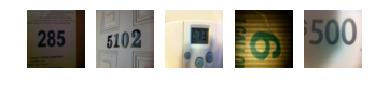

In [67]:
photo_1 = imresize(imread(os.path.join('my_photos/', 'photo 1.JPG')), (54, 54, 3))
photo_2 = imresize(imread(os.path.join('my_photos/', 'photo 2.JPG')), (54, 54, 3))
photo_3 = imresize(imread(os.path.join('my_photos/', 'photo 3.JPG')), (54, 54, 3))
photo_4 = imresize(imread(os.path.join('my_photos/', 'photo 4.JPG')), (54, 54, 3))
photo_5 = imresize(imread(os.path.join('my_photos/', 'photo 5.JPG')), (54, 54, 3))

label_1 = np_utils.to_categorical([2, 8, 5, 10, 10], 11)
label_2 = np_utils.to_categorical([5, 1, 0, 2, 10], 11)
label_3 = np_utils.to_categorical([7, 3, 10, 10, 10], 11)
label_4 = np_utils.to_categorical([6, 10, 10, 10, 10], 11)
label_5 = np_utils.to_categorical([5, 0, 0, 10, 10], 11)


photos = [photo_1, photo_2, photo_3, photo_4, photo_5]
labels = [label_1, label_2, label_3, label_4, label_5]
digit_coords = np.zeros((5, 20))
lengths = np.zeros((5, 5))

for i, photo in enumerate(photos):
    plt.subplot(150 + 1 + i)
    plt.imshow(photo)
    plt.axis('off')

**Answer:**

Yes... difficulties in:

1. Photo 1 - has other verbeage around the numbers which may throw the model off.
2. Photo 2 - has lines around the numbers which may throw the model off as well as the numbers are photographed at an angle which might cause issues.
3. Photo 3 - The numbers is small in scale compared to the rest of the picture.  There are other things in the picture such as the thermostat which might throw the model off as well.
4. Photo 4 - The 'Nine' or 'Six' is rotated 45 degrees as well as other verbeage displayed.
5. Photo 5 - There are lighting and shade issue which may throw the model off.

### Question 8
_Is your model able to perform equally well on captured pictures or a live camera stream when compared to testing on the realistic dataset?_

**Answer:**

Not really.  I've set up my box preds to have values between 0 and 1 and the predictions are coming up as all zeros.  I believe if I have trained my model longer it would account for the accuracy of the bounding box as well, but I believe due to the different scales of loss functions it was maybe prioritizing the catogorical accuracy first.

I achieved an accuracy of about 65% primarily due to identifying the spaces of unused digits.

In [68]:
b = tf.reshape(digit_coords_preds, [-1, num_coords])

# Put the batch into a dict with the proper names
# for placeholder variables in the TensorFlow graph.
feed_dict_test  = {x: np.array(photos).reshape((-1, ) + (img_size_flat,)),
                   y_true: labels,
                   length_true: lengths,
                   digit_coords_true: digit_coords,
                   keep_prob: 1}

# Run the optimizer using this batch of training data.
# TensorFlow assigns the variables in feed_dict_train
# to the placeholder variables and then runs the optimizer.
# a = session.run(a, feed_dict=feed_dict_test)
box_preds = session.run(b, feed_dict=feed_dict_test).reshape(-1, 5, 4)
label_preds = session.run(y_pred_cls, feed_dict=feed_dict_test)

In [69]:
label_preds

array([[ 2,  6, 10, 10, 10],
       [ 2,  9,  4, 10, 10],
       [ 2,  3, 10, 10, 10],
       [ 4,  5, 10, 10, 10],
       [ 2,  9, 10, 10, 10]])

In [70]:
box_preds

array([[[ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.]],

       [[ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.]],

       [[ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.]],

       [[ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.]],

       [[ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.]]], dtype=float32)

### Optional: Question 9
_If necessary, provide documentation for how an interface was built for your model to load and classify newly-acquired images._

**Answer:**

### Question 10
_How well does your model localize numbers on the testing set from the realistic dataset? Do your classification results change at all with localization included?_

**Answer:**

It does a terrible job.  I 'think' I needed to train the model longer to see results from my bounding accuracies.  Unfortunately I don't have the ability to run this model again and find out :(

In [71]:
import cv2

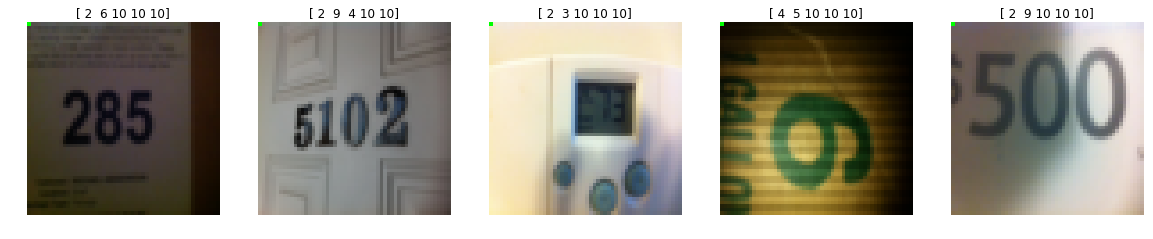

In [72]:
photo_1 = imresize(imread(os.path.join('my_photos/', 'photo 1.JPG')), (54, 54, 3))
photo_2 = imresize(imread(os.path.join('my_photos/', 'photo 2.JPG')), (54, 54, 3))
photo_3 = imresize(imread(os.path.join('my_photos/', 'photo 3.JPG')), (54, 54, 3))
photo_4 = imresize(imread(os.path.join('my_photos/', 'photo 4.JPG')), (54, 54, 3))
photo_5 = imresize(imread(os.path.join('my_photos/', 'photo 5.JPG')), (54, 54, 3))

photos = [photo_1, photo_2, photo_3, photo_4, photo_5]

fig, axes = plt.subplots(1, 5, figsize=(20, 20))
for i, ax in zip(np.arange(5), axes.ravel()):
    for j in range(5):
        photo_width = photos[i].shape[0]
        photo_height = photos[i].shape[1]

        x1 = int(box_preds[i][j][0] * img_size)
        y1 = int(box_preds[i][j][1] * img_size)
        x2 = int(box_preds[i][j][2] * img_size)
        y2 = int(box_preds[i][j][3] * img_size)
        
        cv2.rectangle(photos[i], (x1 , y1 ), 
                                 (x2 , y2 ), (0,255,0), 1)
    ax.imshow(photos[i], interpolation='nearest')
    ax.set_title(label_preds[i])
    ax.set_axis_off()

### Question 11
_Test the localization function on the images you captured in **Step 3**. Does the model accurately calculate a bounding box for the numbers in the images you found? If you did not use a graphical interface, you may need to investigate the bounding boxes by hand._ Provide an example of the localization created on a captured image.

**Answer:**

No it doesn't... please see answer in question 10

----
## Optional Step 5: Build an Application or Program for a Model
Take your project one step further. If you're interested, look to build an Android application or even a more robust Python program that can interface with input images and display the classified numbers and even the bounding boxes. You can for example try to build an augmented reality app by overlaying your answer on the image like the [Word Lens](https://en.wikipedia.org/wiki/Word_Lens) app does.

Loading a TensorFlow model into a camera app on Android is demonstrated in the [TensorFlow Android demo app](https://github.com/tensorflow/tensorflow/tree/master/tensorflow/examples/android), which you can simply modify.

If you decide to explore this optional route, be sure to document your interface and implementation, along with significant results you find. You can see the additional rubric items that you could be evaluated on by [following this link](https://review.udacity.com/#!/rubrics/413/view).

### Optional Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [73]:


### Your optional code implementation goes here.
### Feel free to use as many code cells as needed.



### Documentation
Provide additional documentation sufficient for detailing the implementation of the Android application or Python program for visualizing the classification of numbers in images. It should be clear how the program or application works. Demonstrations should be provided.

_Write your documentation here._

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  
**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.